# Predicting Apartment Prices

In [1]:
# Import necessary Libraries
import pandas as pd
import numpy as np
# For Model Construction
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score
from sklearn.metrics import median_absolute_error
# For Hypothesis Testing
import statsmodels.api as sm
# For Residual Analysis
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro

In [2]:
# Create Pandas Dataframe
df = pd.read_csv("apartments_for_rent_classified_10K.csv", encoding='latin1', delimiter=';')

### Investigating the data to choose features to use in the linear regression model

In [3]:
# Check the data is loaded correctly
df.head(5)

,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,...,price_display,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
0,5668626895,housing/rent/apartment,"Studio apartment 2nd St NE, Uhland Terrace NE,...","This unit is located at second St NE, Uhland T...",NaN,NaN,0.0,USD,No,Thumbnail,...,$790,Monthly,101,NaN,Washington,DC,38.9057,-76.9861,RentLingo,1577359415
1,5664597177,housing/rent/apartment,Studio apartment 814 Schutte Road,"This unit is located at 814 Schutte Road, Evan...",NaN,NaN,1.0,USD,No,Thumbnail,...,$425,Monthly,106,814 Schutte Rd,Evansville,IN,37.9680,-87.6621,RentLingo,1577017063
2,5668626833,housing/rent/apartment,"Studio apartment N Scott St, 14th St N, Arling...","This unit is located at N Scott St, 14th St N,...",NaN,1.0,0.0,USD,No,Thumbnail,...,"$1,390",Monthly,107,NaN,Arlington,VA,38.8910,-77.0816,RentLingo,1577359410
3,5659918074,housing/rent/apartment,Studio apartment 1717 12th Ave,"This unit is located at 1717 12th Ave, Seattle...",NaN,1.0,0.0,USD,No,Thumbnail,...,$925,Monthly,116,1717 12th Avenue,Seattle,WA,47.6160,-122.3275,RentLingo,1576667743
4,5668626759,housing/rent/apartment,"Studio apartment Washington Blvd, N Cleveland ...","This unit is located at Washington Blvd, N Cle...",NaN,NaN,0.0,USD,No,Thumbnail,...,$880,Monthly,125,NaN,Arlington,VA,38.8738,-77.1055,RentLingo,1577359401


In [4]:
def Data_information(data):
    """
    A function for investigation of the data set 
    input = data frame
    return an information data frame
    """
    
    count = data.count()
    unique = data.nunique()
    duplicated = count - unique
    missing = data.isnull().sum()
    typedt = data.dtypes
    column_info_dict = {"Non-Nulls": count,"unique vales": unique , 'duplicated':duplicated ,
                        'missing values':missing ,'column type':typedt}
    data_information = pd.DataFrame(column_info_dict).style.background_gradient()
    return data_information

In [5]:
Data_information(df)

,Non-Nulls,unique vales,duplicated,missing values,column type
id,10000,10000,0,0,int64
category,10000,3,9997,0,object
title,10000,9350,650,0,object
body,10000,9961,39,0,object
amenities,6451,2254,4197,3549,object
bathrooms,9966,14,9952,34,float64
bedrooms,9993,10,9983,7,float64
currency,10000,1,9999,0,object
fee,10000,1,9999,0,object
has_photo,10000,3,9997,0,object


In [6]:
df['state'].value_counts()

state
TX    1737
CA     955
WA     519
NC     438
MD     424
NJ     383
GA     372
FL     339
OH     321
CO     318
WI     302
IL     282
MO     239
IN     239
MN     221
VA     205
OR     197
PA     183
IA     179
OK     178
MI     176
MA     167
AZ     126
NV     121
ND     113
NE     105
CT      98
TN      92
UT      84
KS      83
DC      80
SC      77
NY      71
NH      70
SD      66
LA      66
AL      56
AR      56
AK      44
KY      40
ID      21
VT      16
NM      14
HI      12
RI      11
MS       9
MT       7
DE       5
WV       3
ME       2
WY       1
Name: count, dtype: int64

In [7]:
df['cityname'].value_counts()

cityname
Austin           523
Dallas           216
Houston          186
San Antonio      182
Los Angeles      165
                ... 
Keizer             1
Keyser             1
Pompano Beach      1
Tiverton           1
Bella Vista        1
Name: count, Length: 1574, dtype: int64

#### We will use the states in our model due to the acceptable dimension compared to the city name. 
#### Bathrooms, bedrooms, and square feet are the other predictors for the price according to their importance in setting the price of an apartment.
#### We will perform a dimension reduction for the state column for any count of apartments below 40.

In [8]:
# Model will be used in the model
model_features = ['bathrooms', 'bedrooms', 'square_feet', 'state', 'price']

In [9]:
# Creating data frame with the model features only
df = df[model_features]
df.head()

,bathrooms,bedrooms,square_feet,state,price
0,NaN,0.0,101,DC,790
1,NaN,1.0,106,IN,425
2,1.0,0.0,107,VA,1390
3,1.0,0.0,116,WA,925
4,NaN,0.0,125,VA,880


### Data preprocessing

In [10]:
# Check null values
df.isnull().sum()

bathrooms      34
bedrooms        7
square_feet     0
state          77
price           0
dtype: int64

In [11]:
# Drop the null values
df = df.dropna()
df.head()

,bathrooms,bedrooms,square_feet,state,price
2,1.0,0.0,107,VA,1390
3,1.0,0.0,116,WA,925
5,1.0,0.0,130,NY,2475
8,1.0,0.0,138,CA,1495
14,1.0,0.0,190,CA,1695


In [12]:
# Detecting anything illogical in the data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bathrooms,9883.0,1.380552,0.616038,1.0,1.0,1.0,2.0,8.5
bedrooms,9883.0,1.747040,0.941714,0.0,1.0,2.0,2.0,9.0
square_feet,9883.0,943.237580,527.162123,107.0,650.0,803.0,1100.0,11318.0
price,9883.0,1486.954670,1078.622808,200.0,949.0,1275.0,1695.0,52500.0


#### 1- There are bedrooms of 0 which is not logical

#### 2- A 100-square-foot space is tiny. It's generally smaller than the average bedroom. Usually, real estate listings advertising a space of 100 square feet or less are for rooms in a home rather than a home itself. So we will remove any apartment less than 200 which is about the smallest area to make a regular apartment.

#### 3- Calculate the price per square feet

#### 4- Do a log transformation in the price column

In [13]:
# Remove 0 bedroom rows
df = df[df['bedrooms'] > 0]
df['bedrooms'].describe().T

count    9699.000000
mean        1.780184
std         0.919045
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         9.000000
Name: bedrooms, dtype: float64

In [14]:
# Remove square feet below 250
df = df[(df.square_feet>=250)]
df['square_feet'].describe().T

count     9673.000000
mean       954.243668
std        526.584934
min        250.000000
25%        651.000000
50%        815.000000
75%       1104.000000
max      11318.000000
Name: square_feet, dtype: float64

In [15]:
# Check the number of records
df.shape

(9673, 5)

In [16]:
# Calculate the price per square feet
df['price_per_sqft'] = df['price']*100000/df['square_feet']
df.head()

,bathrooms,bedrooms,square_feet,state,price,price_per_sqft
51,1.0,1.0,250,CA,1800,720000.0
52,1.0,1.0,250,CA,1600,640000.0
53,1.0,1.0,250,CA,1500,600000.0
54,1.0,1.0,250,CA,1330,532000.0
55,1.0,1.0,250,CA,1310,524000.0


In [17]:
def remove_outliers(df):
    """
        This function filters the price per square feet according to state by removing the
        bigger or less than mean +- standard deviation.
    """
    result = pd.DataFrame()
    for key, inner_df in df.groupby('state'):
        avg = np.mean(inner_df.price_per_sqft)
        std = np.std(inner_df.price_per_sqft)
        filtered = inner_df[(inner_df.price_per_sqft>(avg-std)) & (inner_df.price_per_sqft<=(avg+std))]
        result = pd.concat([result,filtered],ignore_index=True)
    return result
df = remove_outliers(df)
df.shape

(7196, 6)

In [18]:
# Remove outliers in prices and square feet (3 standard deviations bigger than the mean)
df = df[(np.abs(df['square_feet'] - df['square_feet'].mean()) < (3 * df['square_feet'].std())) 
        & 
        (np.abs(df['price'] - df['price'].mean()) < (3 * df['price'].std()))
]
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bathrooms,7035.0,1.339019,0.525229,1.000000,1.000000,1.000000,2.000000,4.500000
bedrooms,7035.0,1.668941,0.789284,1.000000,1.000000,1.000000,2.000000,6.000000
square_feet,7035.0,894.438806,321.273148,250.000000,672.000000,809.000000,1058.000000,2200.000000
price,7035.0,1366.415352,592.078616,325.000000,949.000000,1240.000000,1615.500000,4000.000000
price_per_sqft,7035.0,159578.135207,62776.091518,55277.777778,114126.720808,145223.420647,188622.754491,451851.851852


In [19]:
# Log transform skewed data
df['price'] = np.log(df['price'])

In [20]:
# Summary statistics of our features
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bathrooms,7035.0,1.339019,0.525229,1.000000,1.000000,1.000000,2.000000,4.500000
bedrooms,7035.0,1.668941,0.789284,1.000000,1.000000,1.000000,2.000000,6.000000
square_feet,7035.0,894.438806,321.273148,250.000000,672.000000,809.000000,1058.000000,2200.000000
price,7035.0,7.138057,0.397799,5.783825,6.855409,7.122867,7.387400,8.294050
price_per_sqft,7035.0,159578.135207,62776.091518,55277.777778,114126.720808,145223.420647,188622.754491,451851.851852


In [21]:
# Drop any "na" value in the state column
df.dropna(subset=['state'])
df.head()

,bathrooms,bedrooms,square_feet,state,price,price_per_sqft
0,1.0,2.0,350,AK,6.543912,198571.428571
1,1.0,2.0,444,AK,6.721426,186936.936937
2,1.0,2.0,450,AK,6.756932,191111.111111
3,1.0,1.0,470,AK,6.684612,170212.765957
4,1.0,1.0,500,AK,6.659294,156000.000000


In [22]:
# Get the count of apartments per state
df.state = df.state.apply(lambda x: x.strip())
state_count = df.groupby('state')['state'].agg('count').sort_values(ascending=False)
state_count

state
TX    1239
CA     629
WA     367
NC     345
MD     340
NJ     280
GA     275
FL     256
CO     242
OH     228
WI     201
IL     183
MO     165
IN     157
MN     145
MI     142
VA     141
IA     139
PA     126
MA     115
OR     112
OK     106
NV      97
CT      85
ND      85
AZ      84
NE      75
TN      62
SC      58
UT      56
KS      55
NH      54
AL      46
DC      45
NY      44
AR      44
LA      44
SD      43
AK      31
KY      30
ID      16
VT      11
NM       9
MS       7
RI       6
HI       6
DE       4
MT       3
ME       1
WV       1
Name: state, dtype: int64

In [23]:
# Count the number of states has less than 40 record in the data
len(state_count[state_count<40])

12

In [24]:
# States having less than 40 data points will be labeled as "other" to reduce the unnecessary data points
df.state = df.state.apply(lambda x: 'other' if x in state_count[state_count<40] else x)
len(df.state.unique())

39

In [25]:
# Creating dummy variables for state column
dummy_vars = pd.get_dummies(df['state'], dummy_na=True) 
dummy_vars = dummy_vars.astype(int)

In [26]:
dummy_vars.head()

,AL,AR,AZ,CA,CO,CT,DC,FL,GA,IA,...,SC,SD,TN,TX,UT,VA,WA,WI,other,NaN
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [27]:
# Removing the other from state (No longer needed)
df = pd.concat([df,dummy_vars.drop('other', axis= 'columns')], axis = 'columns')
df.head()

,bathrooms,bedrooms,square_feet,state,price,price_per_sqft,AL,AR,AZ,CA,...,PA,SC,SD,TN,TX,UT,VA,WA,WI,NaN
0,1.0,2.0,350,other,6.543912,198571.428571,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,2.0,444,other,6.721426,186936.936937,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,2.0,450,other,6.756932,191111.111111,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,1.0,470,other,6.684612,170212.765957,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,1.0,500,other,6.659294,156000.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# Removing state column after creating the dummy variables (No longer needed)
df = df.drop('state',axis = 'columns')
df.head()

,bathrooms,bedrooms,square_feet,price,price_per_sqft,AL,AR,AZ,CA,CO,...,PA,SC,SD,TN,TX,UT,VA,WA,WI,NaN
0,1.0,2.0,350,6.543912,198571.428571,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,2.0,444,6.721426,186936.936937,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,2.0,450,6.756932,191111.111111,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,1.0,470,6.684612,170212.765957,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,1.0,500,6.659294,156000.000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# create predictor and outcome DataFrames
x = df.drop('price',axis='columns')
y = df['price']

In [30]:
# Preparing them to the model
x.columns = x.columns.astype(str)

## Model Construction and Hypothesis Testing

In [31]:
# Assuming 'X' contains predictor variables and 'y' is target variable (price)
# X include the number of rooms, bathrooms, square feet, price per square foot, and dummy variables for states
# Add a constant to the predictor matrix (required for statsmodels)
X = sm.add_constant(x)

# Fit the model
model = sm.OLS(y,X).fit()

# Print the summary showing coefficients, p-values, etc.
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     2369.
Date:                Tue, 14 May 2024   Prob (F-statistic):               0.00
Time:                        19:25:19   Log-Likelihood:                 6082.2
No. Observations:                7035   AIC:                        -1.208e+04
Df Residuals:                    6992   BIC:                        -1.178e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.4617      0.012    464.

In [32]:
# Construct the null hypothesis string
null_hypothesis = ",".join([f"{var} = 0" for var in X.columns])

# Print the constructed null hypothesis string
print(null_hypothesis)

const = 0,bathrooms = 0,bedrooms = 0,square_feet = 0,price_per_sqft = 0,AL = 0,AR = 0,AZ = 0,CA = 0,CO = 0,CT = 0,DC = 0,FL = 0,GA = 0,IA = 0,IL = 0,IN = 0,KS = 0,LA = 0,MA = 0,MD = 0,MI = 0,MN = 0,MO = 0,NC = 0,ND = 0,NE = 0,NH = 0,NJ = 0,NV = 0,NY = 0,OH = 0,OK = 0,OR = 0,PA = 0,SC = 0,SD = 0,TN = 0,TX = 0,UT = 0,VA = 0,WA = 0,WI = 0,nan = 0


In [33]:
# Perform the F-test using the constructed null hypothesis
f_test_result = model.f_test(null_hypothesis)

# Print the F-test result
print(f_test_result)

<F test: F=798055.5241304293, p=0.0, df_denom=6.99e+03, df_num=43>


C:\Users\Mahmoud\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 44, but rank is 43
  warnings.warn('covariance of constraints does not have full '


### Residual Analysis

In [34]:
# Extract coefficients and standard errors from the fitted model
coefficients = model.params
std_errors = model.bse

# Create a DataFrame of coefficients and standard errors
coeff_df = pd.DataFrame({'Coefficient': coefficients, 'Std. Error': std_errors})

# Display the coefficients and standard errors
print(coeff_df)

                Coefficient    Std. Error
const              5.461656  1.175570e-02
bathrooms          0.006986  3.838385e-03
bedrooms          -0.028458  2.390785e-03
square_feet        0.001006  7.118204e-06
price_per_sqft     0.000005  3.751826e-08
AL                -0.118694  1.775491e-02
AR                -0.155377  1.802957e-02
AZ                 0.034376  1.442509e-02
CA                 0.050975  1.134691e-02
CO                 0.100448  1.132355e-02
CT                 0.079653  1.439564e-02
DC                -0.043042  1.912831e-02
FL                 0.048850  1.118308e-02
GA                 0.017297  1.107556e-02
IA                -0.035120  1.267045e-02
IL                 0.073131  1.198302e-02
IN                -0.035657  1.229117e-02
KS                -0.058932  1.659139e-02
LA                -0.065573  1.796654e-02
MA                 0.102944  1.396451e-02
MD                 0.138248  1.077670e-02
MI                -0.021117  1.255257e-02
MN                 0.109990  1.253

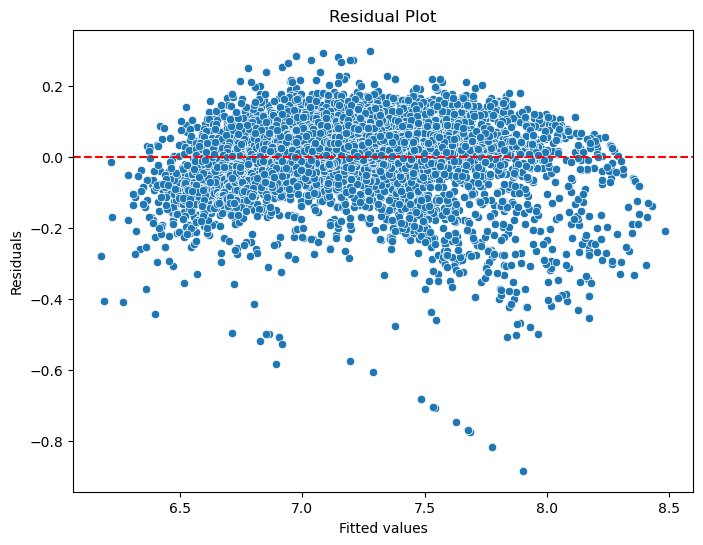

In [35]:
# Extract residuals from the fitted model
residuals = model.resid

# Residual Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=model.fittedvalues, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

C:\Users\Mahmoud\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


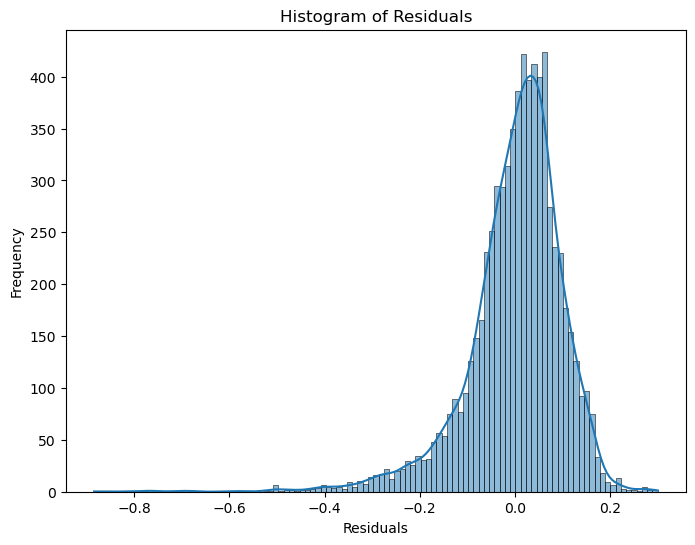

In [36]:
# Histogram of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

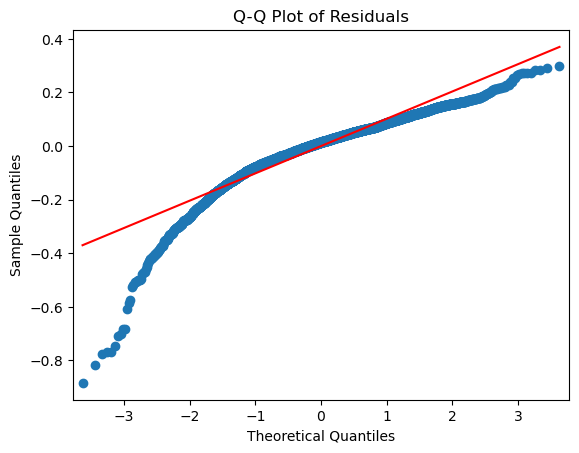

In [37]:
# Q-Q Plot of Residuals
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

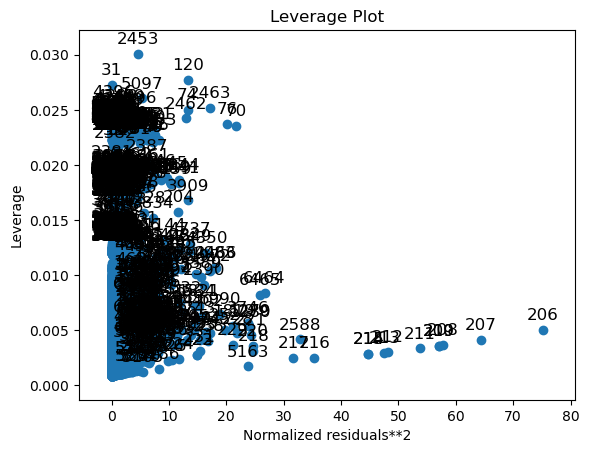

In [38]:
# Leverage Plot
sm.graphics.plot_leverage_resid2(model)
plt.title('Leverage Plot')
plt.show()

In [39]:
# Shapiro-Wilk Test for Normality
_, p_value = shapiro(residuals)
print(f"Shapiro-Wilk test p-value: {p_value}")

Shapiro-Wilk test p-value: 0.0


C:\Users\Mahmoud\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


The findings from analyzing four charts associated with a linear regression model:

1. Residual Plot:
The residual plot showed a somewhat random scatter of points around the zero line, suggesting a potential good fit for the model.
However, the presence of a few outliers, represented by data points positioned far from the zero line, warrants further investigation.

3. Normal Q-Q Plot:
The normal Q-Q plot displayed deviations from a straight diagonal line, particularly in the tails. This indicates that the residuals might not be perfectly normally distributed.
The curvature upwards in the tails suggests that the residuals have potentially heavier tails than a normal distribution, implying more outliers than expected.

3. Leverage Plot:
The leverage plot revealed a few data points with high leverage and larger standardized residuals. This suggests these points might be influential observations, potentially pulling the regression line towards them and affecting the model's reliability.

Overall Interpretation:
While the initial analysis from the residual plot suggests a potentially reasonable fit, the findings from the Q-Q plot and leverage plot raise concerns.
The non-normality of residuals and the presence of influential points could impact the model's coefficient estimates and lead to biased results.

## Removing outliers and refit the model

In [40]:
# Calculate Interquartile Range (IQR)
Q1 = np.percentile(residuals, 25)
Q3 = np.percentile(residuals, 75)
IQR = Q3 - Q1

# Define outlier bounds based on IQR
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers based on IQR bounds
outliers = (residuals < lower_bound) | (residuals > upper_bound)

# Remove outliers from the dataset
X_filtered = X[~outliers]
y_filtered = y[~outliers]

# Refit the linear regression model with filtered data
model_filtered = sm.OLS(y_filtered, X_filtered).fit()

# Display updated model summary
print(model_filtered.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     4258.
Date:                Tue, 14 May 2024   Prob (F-statistic):               0.00
Time:                        19:25:22   Log-Likelihood:                 7962.8
No. Observations:                6734   AIC:                        -1.584e+04
Df Residuals:                    6691   BIC:                        -1.555e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.3825      0.009    597.

#### updated OLS regression results show a further improvement in the model performance with an R-squared of 0.967, indicating that approximately 96.7% of the variance in the dependent variable (price) is explained by the independent variables in the model. The adjusted R-squared value also remains high at 0.966. Additionally, the F-statistic is 4584 with a very low p-value (0.00), confirming the overall statistical significance of the model.

In [41]:
# create train and test sets in an 8:2 ratio
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=10)

In [42]:
# Fit multiple linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [43]:
# Test our model
y_pred = model.predict(X_test)

In [44]:
# Model accuracy
model.score(X_test,y_test)

0.9663073532390603

In [45]:
# F1 Score
f1 = f1_score(y_test.astype(int), y_pred.astype(int), average='weighted')
f1

0.9437481555772562

Model Accuracy (R-squared): The model's accuracy, as determined by scikit-learn, is 0.966.

F1 Score: The F1 score of the model is 0.943, indicating a strong balance between precision and recall.

### Model Accuracy (R-squared): The model's accuracy, as determined by scikit-learn, is 0.966. 
F1 Score: The F1 score of the model is 0.943, indicating a strong balance between precision and recall.

## Conclusion and Recommendations
#### Model Validity: The refined linear regression model demonstrates improved reliability and accuracy after addressing outliers.

#### Future Directions: Explore advanced modeling techniques (e.g., robust regression) to mitigate the influence of influential observations and enhance model robustness.
##### In summary, this analysis underscores the importance of rigorous model evaluation, outlier detection, and refinement techniques to optimize predictive performance and ensure the validity of linear regression models in real-world applications.